<font size="10">Discovering Conjugate Mappings: Conjugacy Between the Rossler Poincare Map and the Logistic map</font>

<font size="4">This notebook employs an autoencoder neural network structure to discover a conjugacy between the Poincare map of the Rossler system and the logistic map. The 1-dimensional Poincare mapping (observed in collected data) has a single quadratic maximum, thus displaying the characteristic period-doubling into chaos phenomenon. We take advantage of this to establish a conjugacy between this Poincare map (at specific parameter values) and the logistic map 
$x_{n+1} = c_1x_n + c_2x_n^2$, where $c_1 > 0$ and $c_2 < 0$ are trainable neural network parameters. The result is a method of discovering conjugate mappings by simultaneous identifying the simplifying transform (the conjugacy/encoder), its inverse (the decoder), and the conjugate dynamics (the logsitic function).  </font>

<font size="4">This code was written by Mohit Sahu and accompanies the work in Section 6.5 of the book. <i>Data-Driven Methods for Dynamic Systems</i>. This script was adapted from the Tensorflow version by Jason J. Bramburger. We use PyTorch 2.3.0 to build the neural network</font>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [2]:
# Rossler right-hand-side
def Rossler(x,t,c = 18):
    a = 0.1
    b = 0.1

    dxdt = [-x[1] - x[2], x[0] + a*x[1], b + x[2]*(x[0] - c)]
    return dxdt

In [3]:
# Continuous-time simulation data

# Initializations
dt = .005
t_span = np.arange(0, 50000, dt)
x0 = [0, -15, 0]
c = 18

# Solution data
xsol = []
xsol = odeint(Rossler, x0, t_span, args = (c,))

Text(0, 0.5, '$y(t)$')

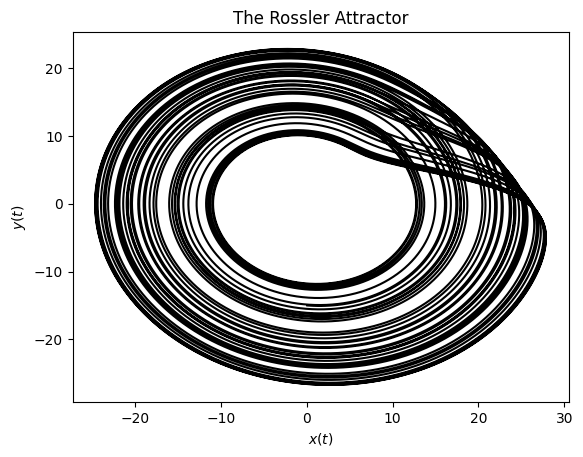

In [ ]:
# Plot Rossler Solution (x_2 vs. x_1)

plt.plot(xsol[1:50000,0],xsol[1:50000,1],'k')
plt.title("The Rossler Attractor")
plt.xlabel("$x(t)$")
plt.ylabel("$y(t)$")

In [4]:
# Create section data
Psec = []
temp = [0]*len(xsol[:,1])
count = 0
for m in range(len(temp)-1):
    if xsol[m,0] <= 0 and xsol[m+1,0] >= 0: # section condition
        temp[count] = xsol[m+1,1]
        count = count + 1
Psec.append(np.array(temp[1:count]))

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
N = 8000
xn = np.zeros((N,1))
xnp1 = np.zeros((N,1))

for n in range(N):
    xn[n] = Psec[0][n]
    xnp1[n] = Psec[0][n+1]

#Scale data into [0,1]
max_xn = xn.max()
min_xn = xn.min()

slope = 1/(max_xn - min_xn)
yint = -slope*min_xn

# Print scaling terms
print(slope)
print(yint)

xn = slope*xn + yint
xnp1 = slope*xnp1 + yint

# Build input data matrix of forward iterates
forward_iters = 10
xnforward = []

xnp1 = xnp1[:-forward_iters]
for j in range(forward_iters):
    xnforward.append(torch.tensor(xn[j:-forward_iters+j], dtype=torch.float32).to(device))

xnforward = torch.permute(torch.stack(xnforward), (1, 2, 0))

0.06734232735515494
1.7917506357736845


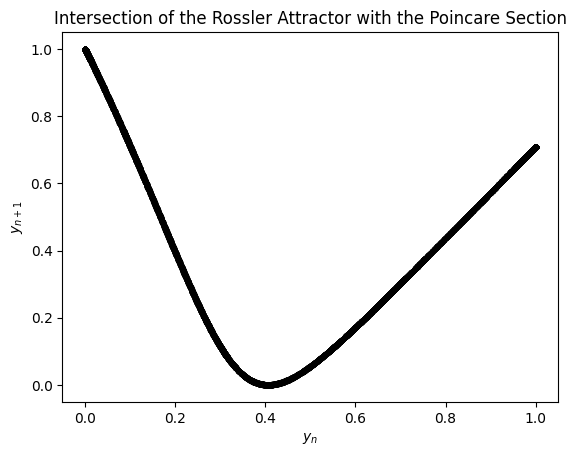

In [ ]:
# Plot Rossler Section Data

# Plot the original Poincare section data
# plt.plot(Psec[0][:-1],Psec[0][1:],'k.')

# Plot the scaled and shifted Poincare section data
plt.plot(xnforward[0].detach(),xnforward[1].detach(),'k.')

# Plot labels
plt.title("Intersection of the Rossler Attractor with the Poincare Section")
plt.xlabel("$y_n$")
plt.ylabel("$y_{n+1}$");

In [ ]:
# Conjugacy neural network architecture

class Conjugacy(nn.Module):
    def __init__(self,
                 width = 100,
                 size_x = 1,
                 size_y = 1,
                 activation = nn.SELU(),
                 steps = 1,
                 numblksIn = 1,
                 numblksOut = 1,
                 l1reg = 1e-15,
                 l2reg = 1e-15,
                 **kwargs):
        super(Conjugacy, self).__init__()
        self.width = width
        self.size_x = size_x
        self.size_y = size_y
        self.activation = activation
        self.steps = steps
        self.numblksIn = numblksIn
        self.numblksOut = numblksOut
        self.l1reg = l1reg
        self.l2reg = l2reg

        # Trainable network parameter
        self.c1 = nn.Parameter(torch.tensor(3.9661386, requires_grad=True))
        self.c2 = nn.Parameter(torch.tensor( -4.671839, requires_grad=True) )

        # Encoder function
        encoder_layers = [nn.Linear(self.size_x, self.width), self.activation]
        for _ in range(self.numblksIn-1):  # adding more layers
            encoder_layers.append(nn.Linear(self.width, self.width))
            encoder_layers.append(self.activation)

        encoder_layers.append(nn.Linear(self.width, size_y))
        encoder_layers.append(self.activation)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder Function
        decoder_layers = [nn.Linear(self.size_y, self.width), self.activation]
        for _ in range(self.numblksOut-1):  # adding more layers
            decoder_layers.append(nn.Linear(self.width, self.width))
            decoder_layers.append(self.activation)

        decoder_layers.append(nn.Linear(self.width, size_x))
        decoder_layers.append(self.activation)
        self.decoder = nn.Sequential(*decoder_layers)

        # Initialize weights in the model
        self.apply(self._initialize_weight)

    def _initialize_weight(self, module):
        if isinstance(module, nn.Linear):
            # apply a normal distribution to the weights and bias
            nn.init.normal_(module.weight, mean=0.0, std=0.1)
            nn.init.normal_(module.bias, mean=0.0, std=0.1)

    def forward(self, x):
        encoded = self.encoder(x[:,:,0])
        encoded_p1 = self.c1*encoded + self.c2*torch.square(encoded)
        decoded = self.decoder(encoded_p1)

        # Conjugacy loss
        x_recon = self.decoder(encoded)
        loss = torch.mean(torch.square(x[:,:,0] - x_recon))

        # Build loss function
        yn = encoded
        for s in range(self.steps):
            ynp1 = self.encoder(x[:,:,s+1])

            # Iteration loss in y
            y_step = self.c1*yn + self.c2*torch.square(yn)
            loss += torch.mean(torch.square(ynp1 - y_step))/self.steps

            # Iteration loss in x
            xnp1 = self.decoder(y_step)
            loss += torch.mean(torch.square(x[:,:,s+1] - xnp1))/self.steps

            yn = y_step

        # # L1L2 Regularization loss
        loss += sum(self.l1reg*p.abs().sum() for p in self.encoder.parameters()) + self.l1reg*sum(p.abs().sum() for p in self.decoder.parameters())  # L1 Loss
        loss += sum(self.l2reg*p.pow(2).sum() for p in self.encoder.parameters()) + self.l2reg*sum(p.pow(2).sum() for p in self.decoder.parameters())  # L2 Loss

        return decoded, loss

In [7]:
# Neural Network Parameters

width = 100 # width of each NN layer
size_x = 1 # number of variables in the tent map
size_y = 1 # number of variables in the logistic map
activation = nn.SELU() # nonlinear activation function at each NN layer
steps = 1 # Number of steps for loss function
learning_rate = 0.00001
numblks_in = 1 # number of layers for the encoder NN
numblks_out = 1 # number of layers for the decoder NN

conjugacy = Conjugacy(width, size_x, size_y, activation, steps, numblks_in, numblks_out).to(device)
optimizer = optim.Adam(conjugacy.parameters(), lr=learning_rate)

train_dataloader = DataLoader(xnforward, batch_size=32)

In [8]:
def train(model, optimizer, epochs=10, patience=100):
    model.train()
    best_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        min_loss = float('inf')
        for xt in train_dataloader:
            optimizer.zero_grad()
            decoded, loss = model(xt)
            loss.backward()
            optimizer.step()

            min_loss  = min(min_loss, loss.item())

        print(f"Epoch {epoch+1}/{epochs}, Loss: {min_loss}")

        if min_loss < best_loss:
            best_loss = min_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

train(conjugacy, optimizer, epochs=100)

Epoch 1/100, Loss: 1.925639033317566
Epoch 2/100, Loss: 1.045770525932312
Epoch 3/100, Loss: 0.6057494282722473
Epoch 4/100, Loss: 0.38730868697166443
Epoch 5/100, Loss: 0.2755056917667389
Epoch 6/100, Loss: 0.21520860493183136
Epoch 7/100, Loss: 0.18148092925548553
Epoch 8/100, Loss: 0.1618967056274414
Epoch 9/100, Loss: 0.15138229727745056
Epoch 10/100, Loss: 0.14547978341579437
Epoch 11/100, Loss: 0.1417241096496582
Epoch 12/100, Loss: 0.1392829418182373
Epoch 13/100, Loss: 0.13765475153923035
Epoch 14/100, Loss: 0.13650110363960266
Epoch 15/100, Loss: 0.13566060364246368
Epoch 16/100, Loss: 0.13504943251609802
Epoch 17/100, Loss: 0.1346358358860016
Epoch 18/100, Loss: 0.13437020778656006
Epoch 19/100, Loss: 0.13421231508255005
Epoch 20/100, Loss: 0.13412025570869446
Epoch 21/100, Loss: 0.1340731978416443
Epoch 22/100, Loss: 0.13403569161891937
Epoch 23/100, Loss: 0.13400232791900635
Epoch 24/100, Loss: 0.13396058976650238
Epoch 25/100, Loss: 0.13397249579429626
Epoch 26/100, Loss: 

In [11]:
# Check performance of trained neural network

# Print logistic variables
print(conjugacy.c1.detach(), '\t * y')
print(conjugacy.c2.detach(), '\t * y^2')
print('')

# Apply network components to the data
yn = conjugacy.encoder(xnforward[:,:,0])
xn_recon = conjugacy.decoder(yn)
ynp1 = conjugacy.c1*yn + conjugacy.c2*torch.square(yn)
xnp1_recon = conjugacy.decoder(ynp1)
# ynp1_2 = conjugacy.encoder(xnp1)

# Print data results
print(xnforward[:,:,0])
print('')
print(xn_recon.detach())
print('')
print(xnp1)
print('')
print(xnp1_recon.detach())

tensor(4.0914) 	 * y
tensor(-4.6969) 	 * y^2

tensor([[4.1148e-01],
        [6.8200e-04],
        [9.9908e-01],
        ...,
        [4.6210e-01],
        [2.2823e-02],
        [9.3832e-01]])

tensor([[0.3182],
        [0.5266],
        [0.5154],
        ...,
        [0.3301],
        [0.5125],
        [0.4882]])

[[6.81997623e-04]
 [9.99083105e-01]
 [7.07995145e-01]
 ...
 [2.28231630e-02]
 [9.38321240e-01]
 [6.25122083e-01]]

tensor([[0.0135],
        [0.8740],
        [0.8258],
        ...,
        [0.0591],
        [0.8131],
        [0.7088]])


In [8]:
# Loading and view the saved model
import tensorflow as tf

def loadModel(file_path, numblksIn=1, numblksOut=1, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    tf_model = tf.keras.models.load_model(file_path, compile=False)

    conju_wt = tf_model.get_weights()
    conju_wt = [torch.tensor(cmc, dtype=torch.float32).to(device) for cmc in conju_wt]

    pytorch_model = Conjugacy(numblksIn=numblksIn, numblksOut=numblksOut).to(device)
    for i in range(numblksIn+1):
        pytorch_model.encoder[2*i].weight = nn.Parameter(conju_wt[2*i].T)
        pytorch_model.encoder[2*i].bias = nn.Parameter(conju_wt[2*i+1])

    for i in range(numblksOut+1):
        pytorch_model.decoder[2*i].weight = nn.Parameter(conju_wt[2*(i+numblksIn+1)].T)
        pytorch_model.decoder[2*i].bias = nn.Parameter(conju_wt[2*(i+numblksIn+1)+1])

    # load variables
    variables = [
        'pytorch_model.c1 = nn.Parameter(torch.tensor(tf_model.c1.numpy()))',
        'pytorch_model.c2 = nn.Parameter(torch.tensor(tf_model.c2.numpy()))',
    ]

    for line in variables:
        try:
            exec(line)
        except Exception as e:
            pass

    return pytorch_model

conjugacy = loadModel("../saved_conjugacy_networks/rossler_c=18")

tensor(3.9661) 	 * y
tensor(-4.6718) 	 * y^2

tensor([[4.1149e-01],
        [7.0477e-04],
        [9.9907e-01],
        ...,
        [2.3642e-02],
        [9.3615e-01],
        [6.2217e-01]])

tensor([[0.4210],
        [0.0151],
        [0.9851],
        ...,
        [0.0259],
        [0.9314],
        [0.6313]])

[[7.04769972e-04]
 [9.99070520e-01]
 [7.07992868e-01]
 ...
 [9.36145058e-01]
 [6.22171000e-01]
 [1.99685705e-01]]

tensor([[0.0094],
        [0.9862],
        [0.7065],
        ...,
        [0.9373],
        [0.6192],
        [0.1997]])


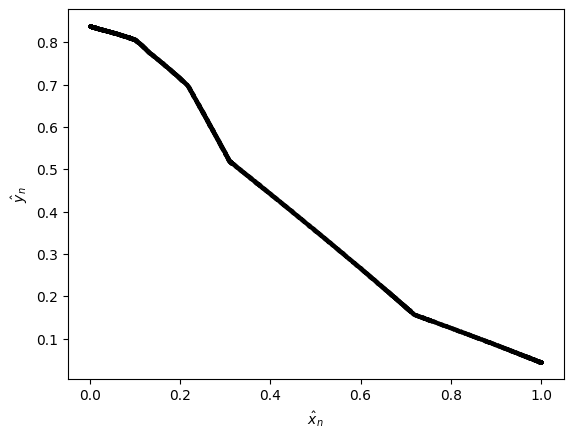

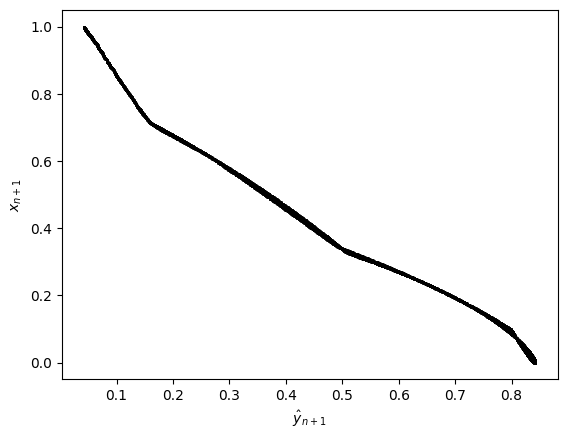

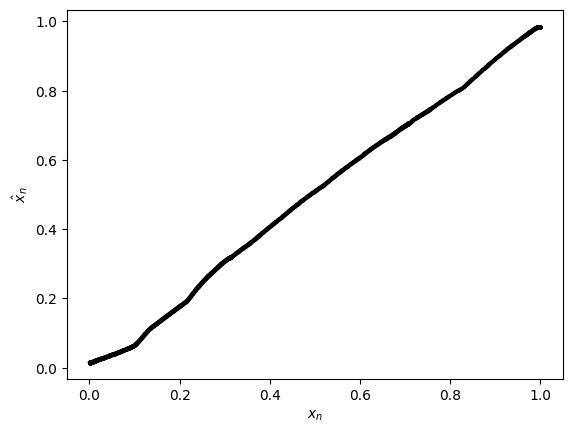

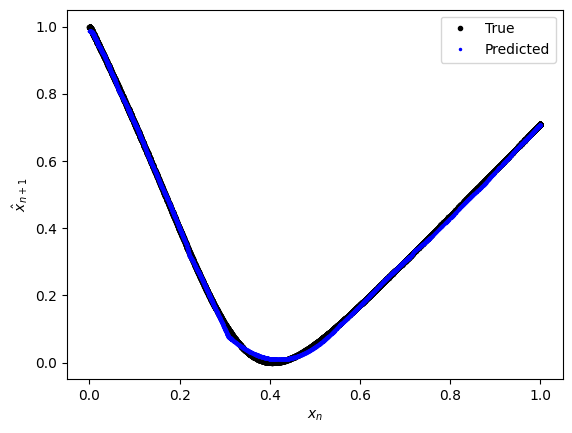

In [9]:
# Check performance of trained neural network

# Print logistic variables
print(conjugacy.c1.detach(), '\t * y')
print(conjugacy.c2.detach(), '\t * y^2')
print('')

# Apply network components to the data
yn = conjugacy.encoder(xnforward[:,:,0])
xn_recon = conjugacy.decoder(yn)
ynp1 = conjugacy.c1*yn + conjugacy.c2*torch.square(yn)
xnp1_recon = conjugacy.decoder(ynp1)
# ynp1_2 = conjugacy.encoder(xnp1)

# Print data results
print(xnforward[:,:,0])
print('')
print(xn_recon.detach())
print('')
print(xnp1)
print('')
print(xnp1_recon.detach())

fig = plt.figure()
plt.plot(xnforward[:,:,0].detach(), yn.detach(), 'k.', markersize=3)
plt.xlabel('$\hat x_{n}$')
plt.ylabel('$\hat y_{n}$')

plt.show()

fig2 = plt.figure()
plt.plot(ynp1.detach(), xnp1, 'k.', markersize=2)
plt.xlabel('$\hat y_{n+1}$')
plt.ylabel('$ x_{n+1}$')

plt.show()

fig3 = plt.figure()
plt.plot(xnforward[:,:,0].detach(), xn_recon.detach(), 'k.', markersize=3)
plt.xlabel('$x_n$')
plt.ylabel('$\hat x_{n}$')

plt.show()

fig4 = plt.figure()
plt.plot(xnforward[:,:,0].detach(), xnp1,'k.', label='True')
plt.plot(xnforward[:,:,0].detach(), xnp1_recon.detach(), 'b.', markersize=3, label='Predicted')
plt.xlabel('$x_n$')
plt.ylabel('$\hat x_{n+1}$')
plt.legend()

plt.show()

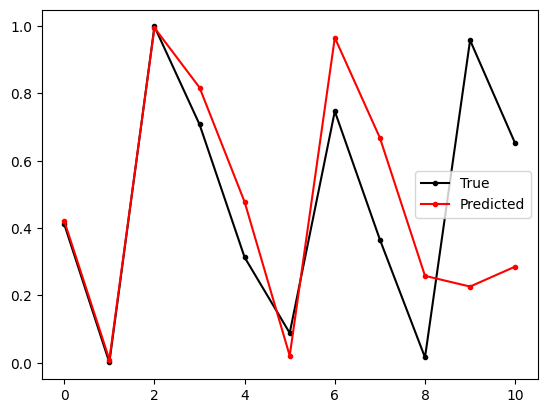

In [10]:
# Iterating the conjugacy mapping
iters = 10
start = 0
ypred = [yn[start]]
for i in range(iters):
    ypred.append(conjugacy.c1*ypred[i] + conjugacy.c2*torch.square(ypred[i]))

ypred = torch.stack(ypred)

xpred = conjugacy.decoder(ypred)
fig1 = plt.figure()
plt.plot(xn[start:start+iters+1],'k.-', label='True')
plt.plot(xpred.cpu().detach(),'r.-', label='Predicted')
plt.legend()